In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print(f"Pytorch version {torch.__version__}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device:{device}")

Pytorch version 1.10.0+cu111
device:cuda:0


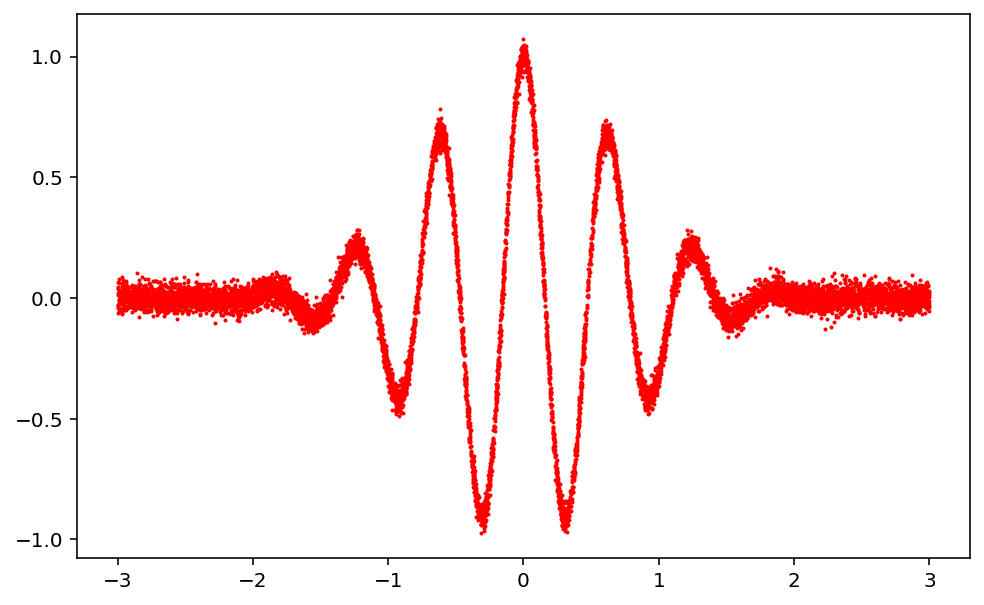

In [20]:
# dataset
n_data = 10000
x_numpy = -3+6*np.random.rand(n_data, 1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data, 1)

plt.figure(figsize=(8,5))
plt.plot(x_numpy, y_numpy, 'r.', ms=2)
plt.show()

x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)

In [9]:
# define model
class Model(nn.Module) :
    def __init__(self, name='mlp', xdim=1, hdims=[16,16], ydim=1):
        super(Model, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdims = hdims
        self.ydim = ydim

        self.layers = []
        # input
        prev_hdim = self.xdim
        # hdim
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim, hdim, bias=True))
            self.layers.append(nn.Tanh())
            prev_hdim = hdim
        # output
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))

        # concat
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = f"{type(layer).__name__.lower()}_{l_idx}"
            self.net.add_module(layer_name, layer)
        
        self.init_param()

    def init_param(self):
        for m in self.modules() :
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)

In [12]:
LEARNING_RATE = 1e-2

# Instance Models with different optimizer
model_sgd = Model(name='mlp_sgd', xdim=1, hdims=[64,64], ydim=1).to(device)
model_momentum = Model(name='mlp_momentum', xdim=1, hdims=[64,64], ydim=1).to(device)
model_adam = Model(name='mlp_adam', xdim=1, hdims=[64,64], ydim=1).to(device)

# Optimize
loss = nn.MSELoss()
optm_sgd = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)
optm_momentum = optim.SGD(model_momentum.parameters(), lr=LEARNING_RATE, momentum=0.9)
optm_adam = optim.Adam(model_adam.parameters(), lr=LEARNING_RATE)

In [15]:
# check parameter

np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad :
        param_numpy = param.detach().cpu().numpy()
        n_param += len(param_numpy.reshape(-1))
        print(f"{p_idx} name : {param_name} shape : {param_numpy.shape}")
        print(f"   val : {param_numpy.reshape(-1)[:5]}")
print(f"Total number of parameters : {format(n_param, ',d')}")

0 name : net.linear_0.weight shape : (64, 1)
   val : [-1.699 -0.545  1.731  3.371  0.506]
1 name : net.linear_0.bias shape : (64,)
   val : [0. 0. 0. 0. 0.]
2 name : net.linear_2.weight shape : (64, 64)
   val : [-0.23   0.105  0.216 -0.057 -0.156]
3 name : net.linear_2.bias shape : (64,)
   val : [0. 0. 0. 0. 0.]
4 name : net.linear_4.weight shape : (1, 64)
   val : [ 0.067 -0.147 -0.155  0.106  0.013]
5 name : net.linear_4.bias shape : (1,)
   val : [0.]
Total number of parameters : 4,353


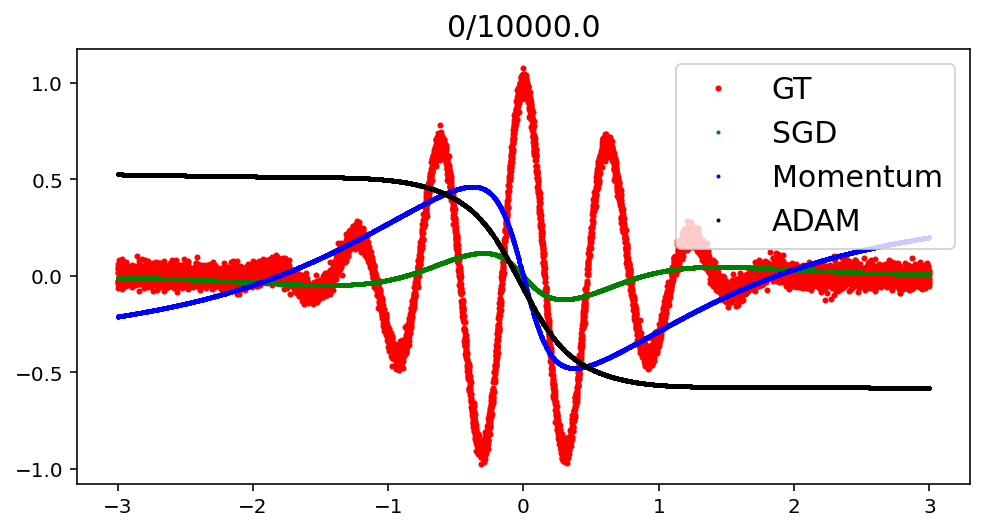

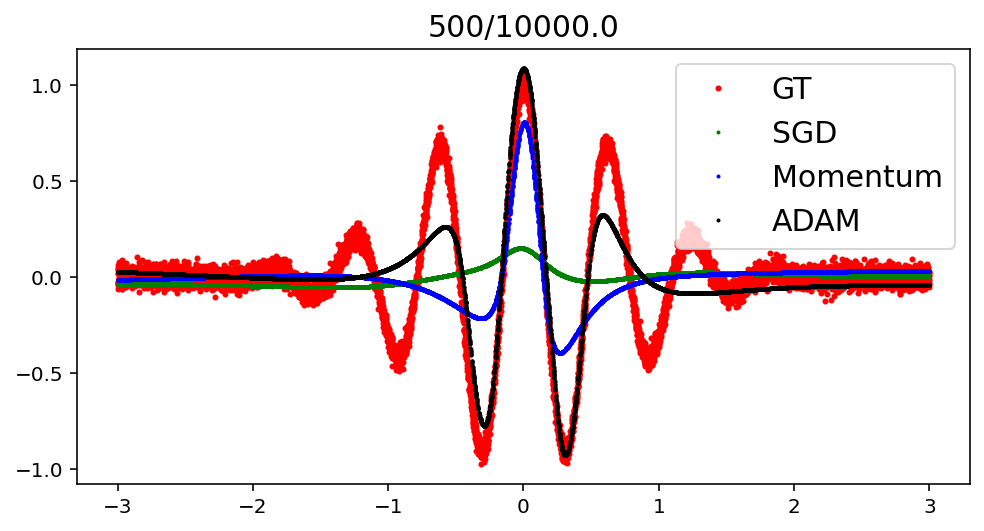

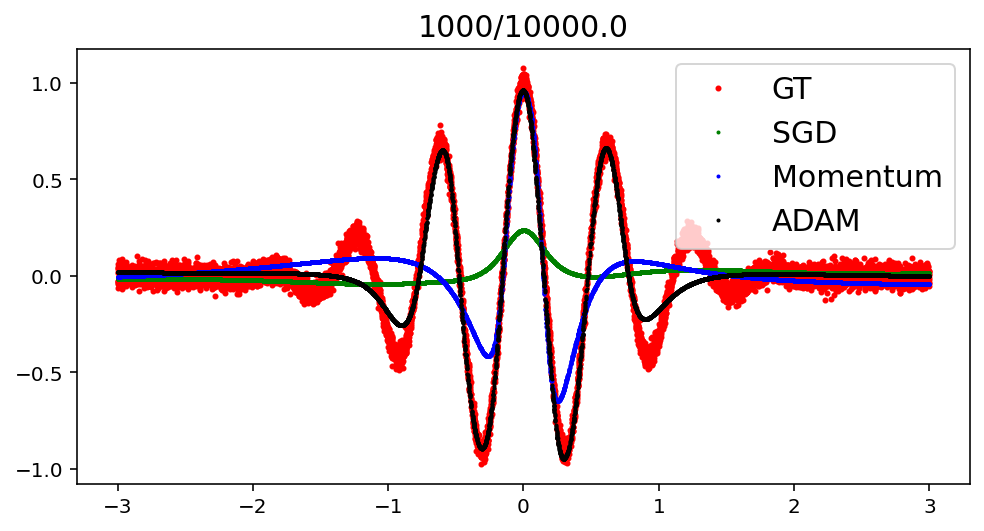

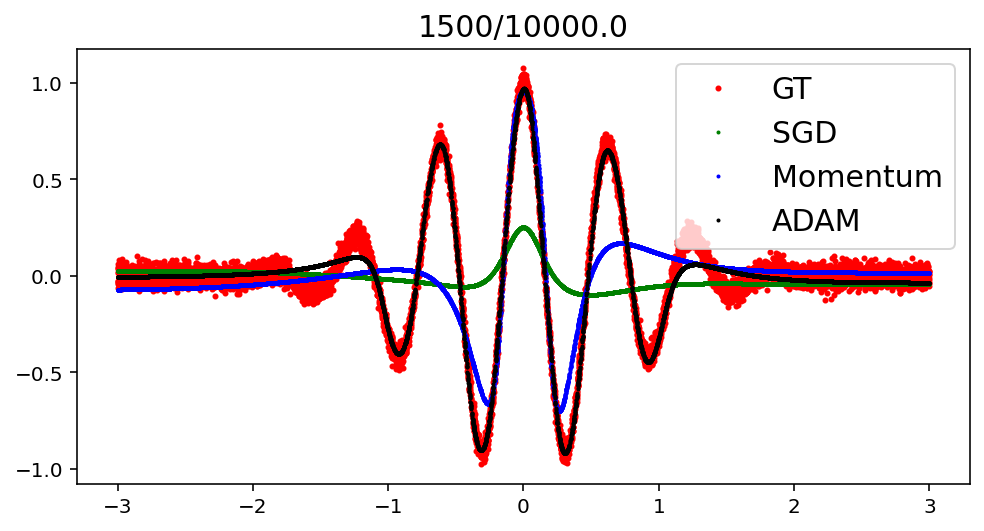

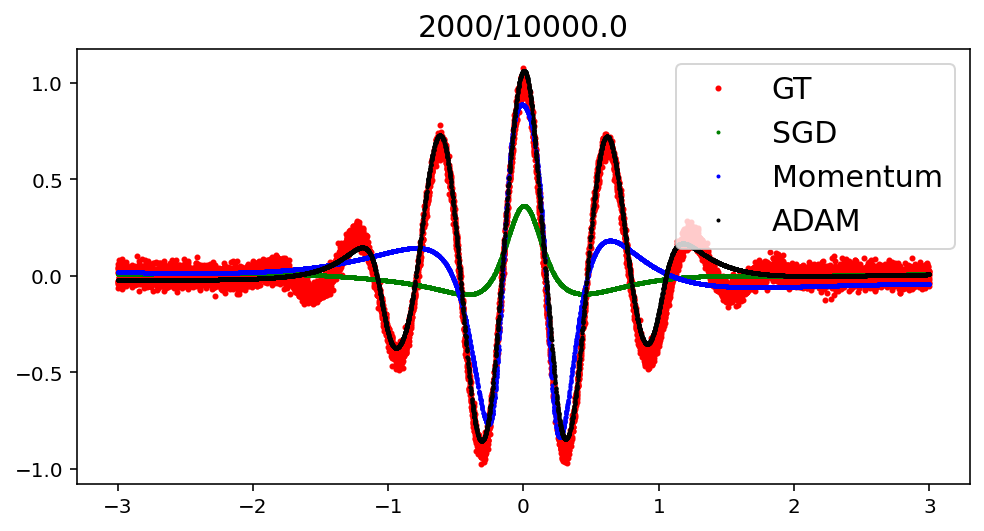

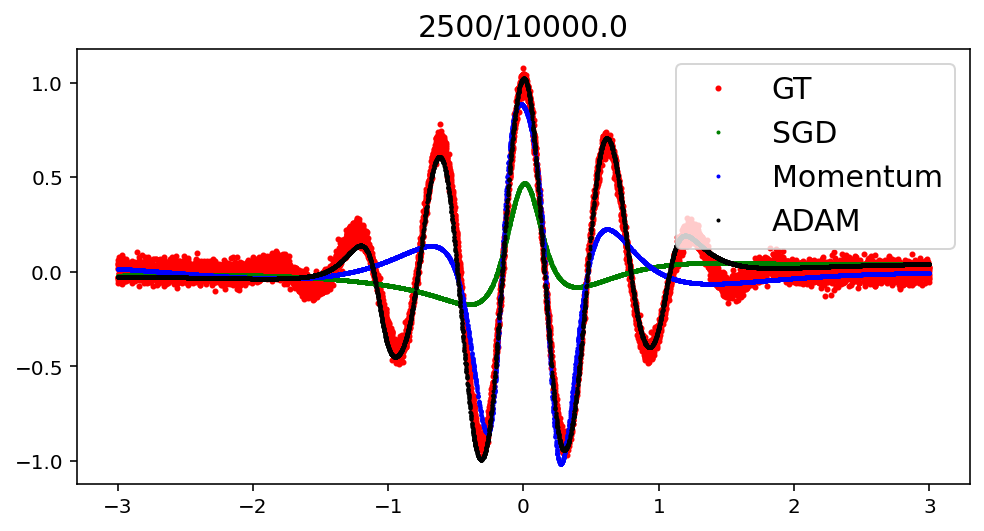

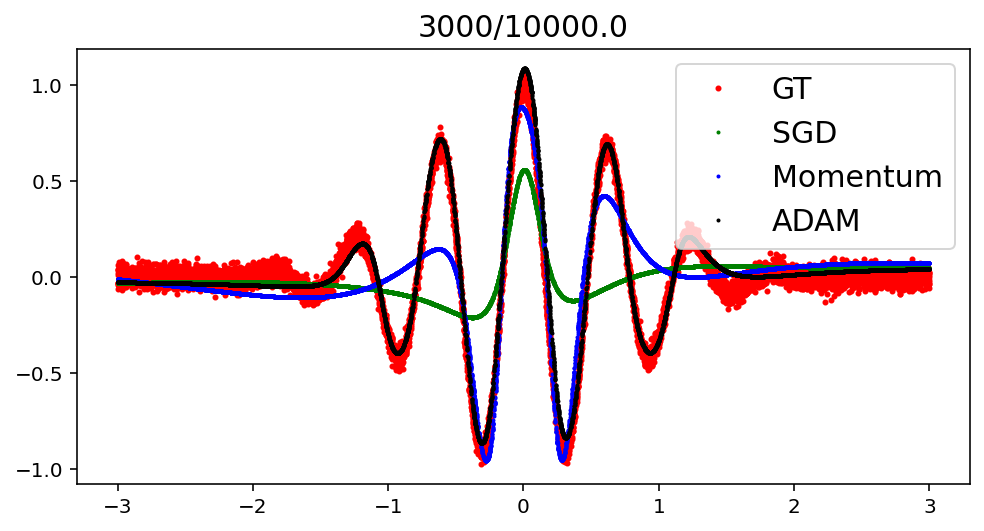

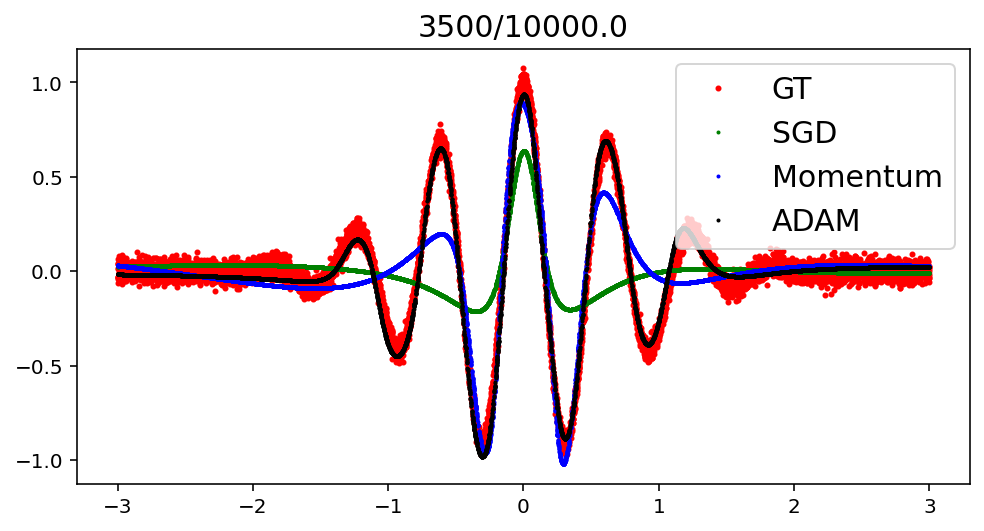

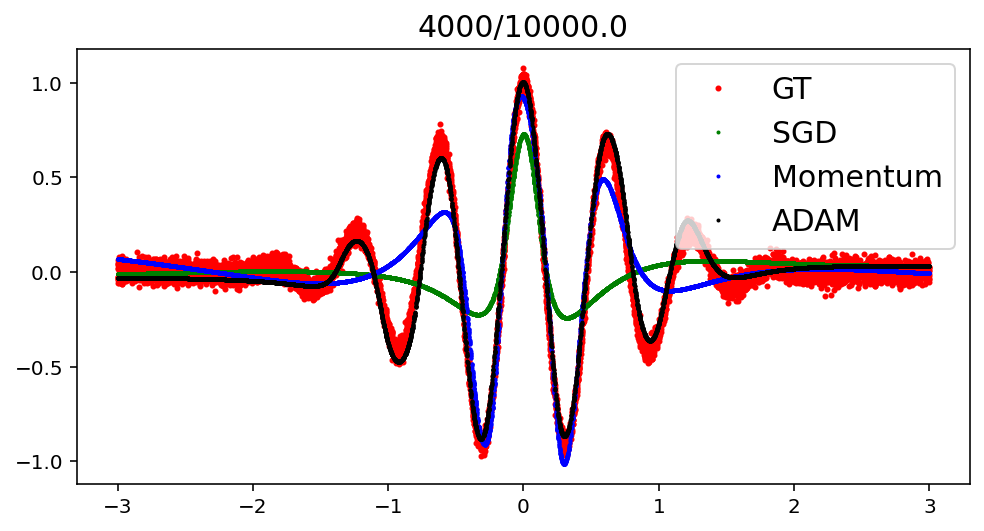

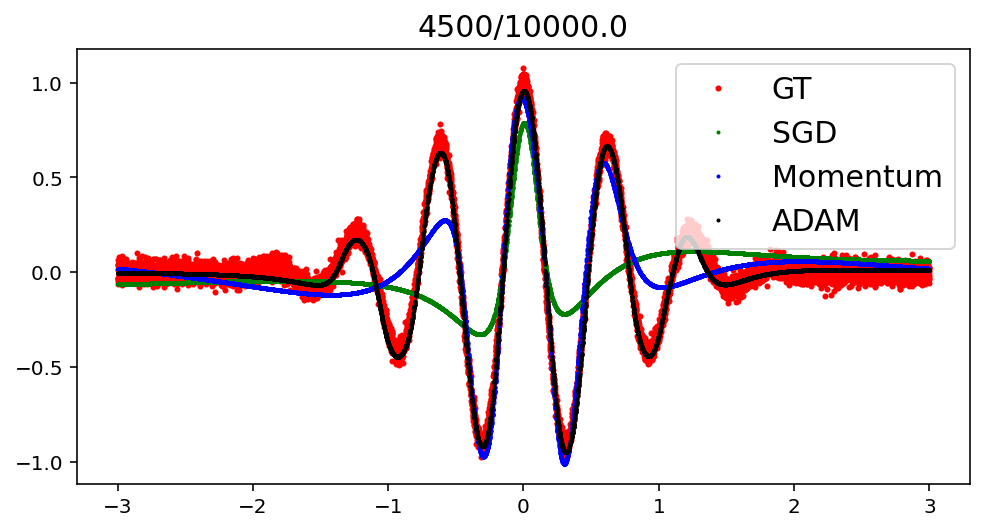

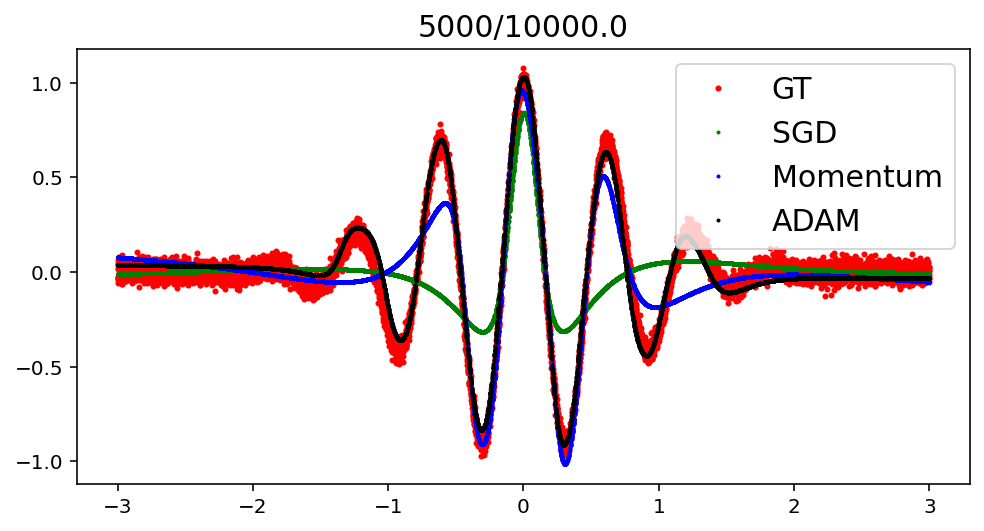

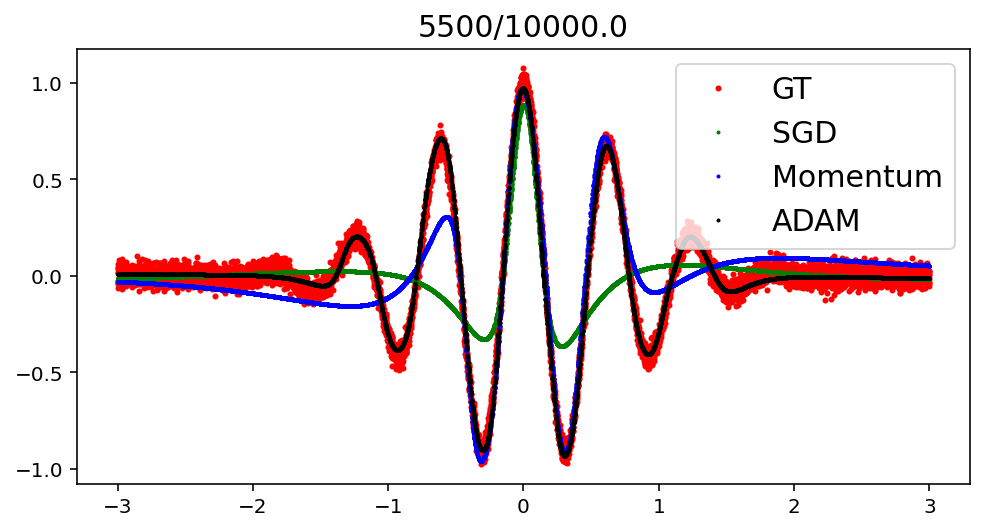

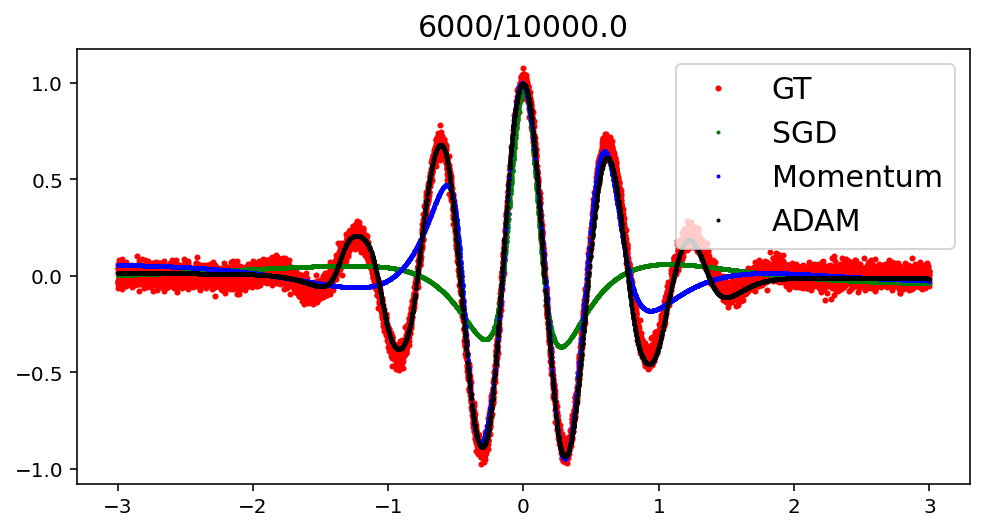

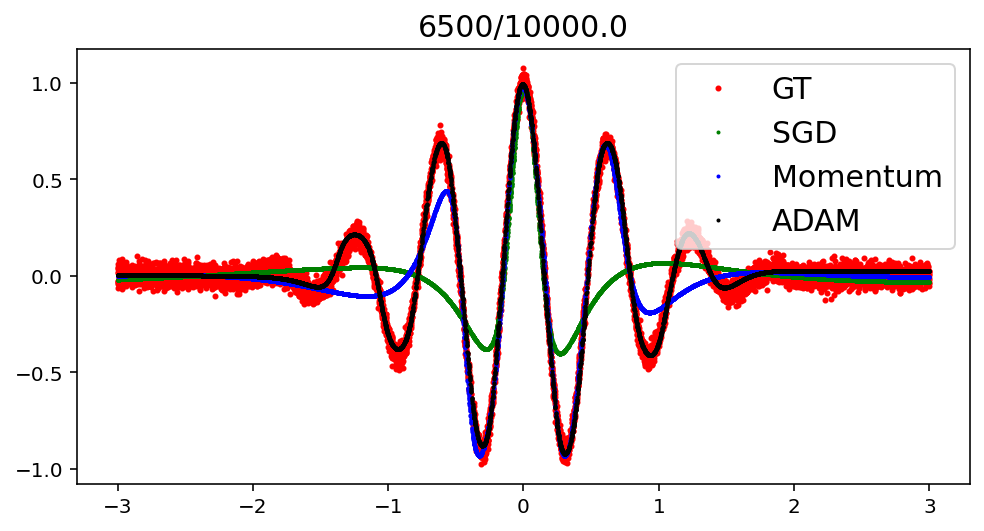

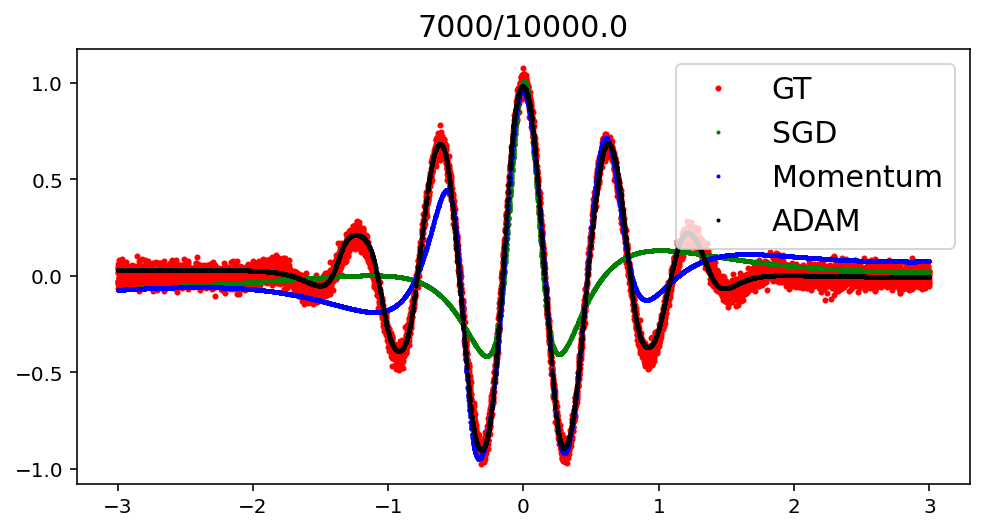

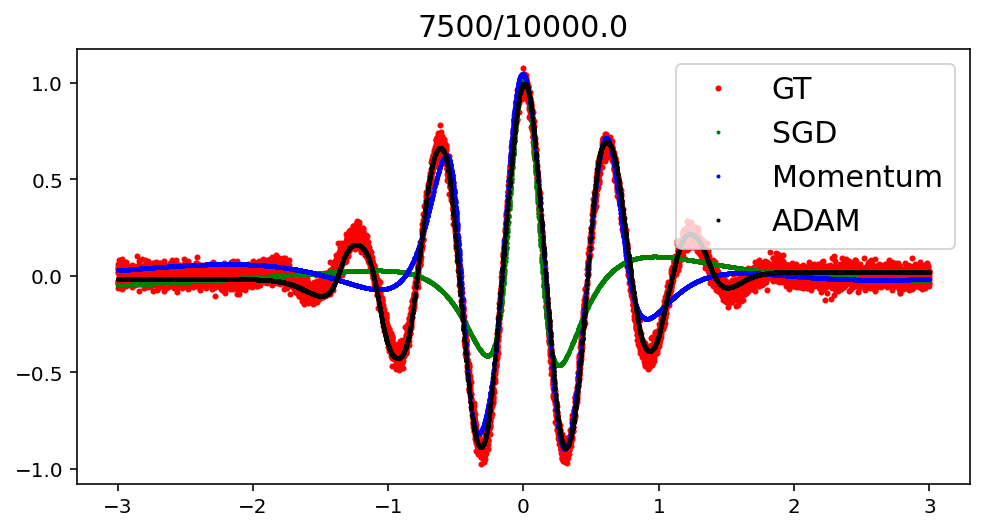

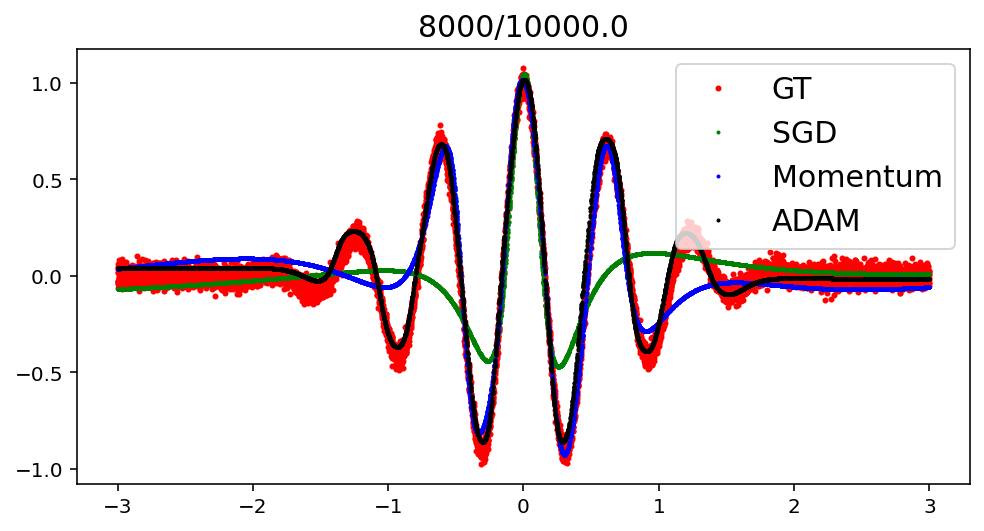

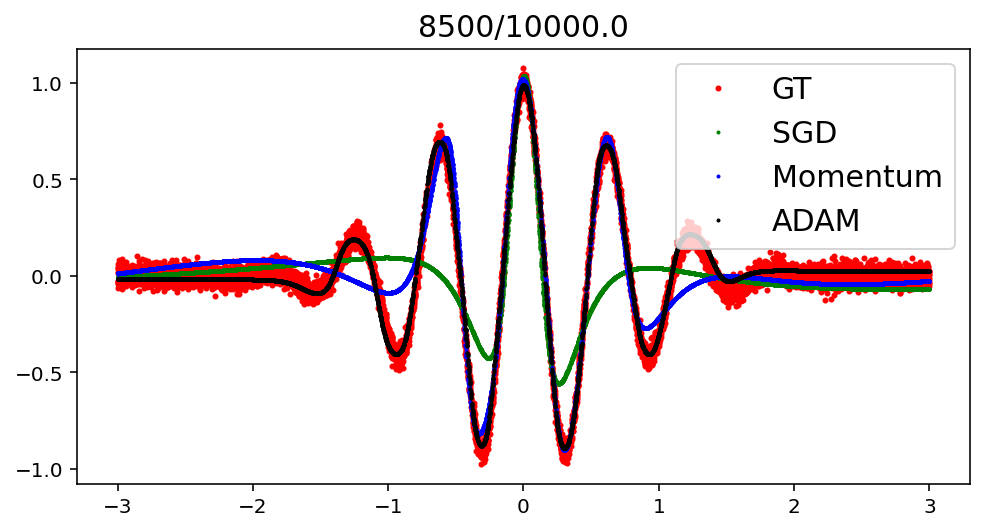

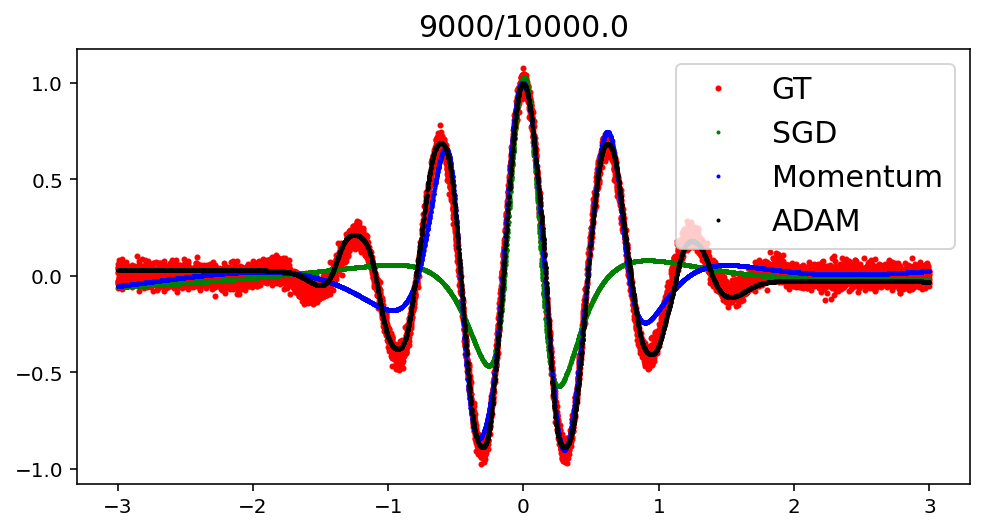

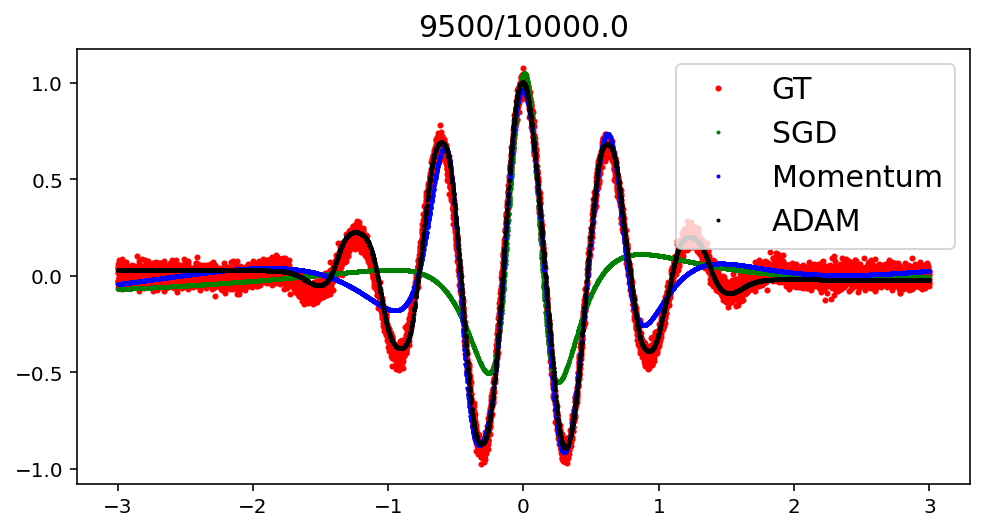

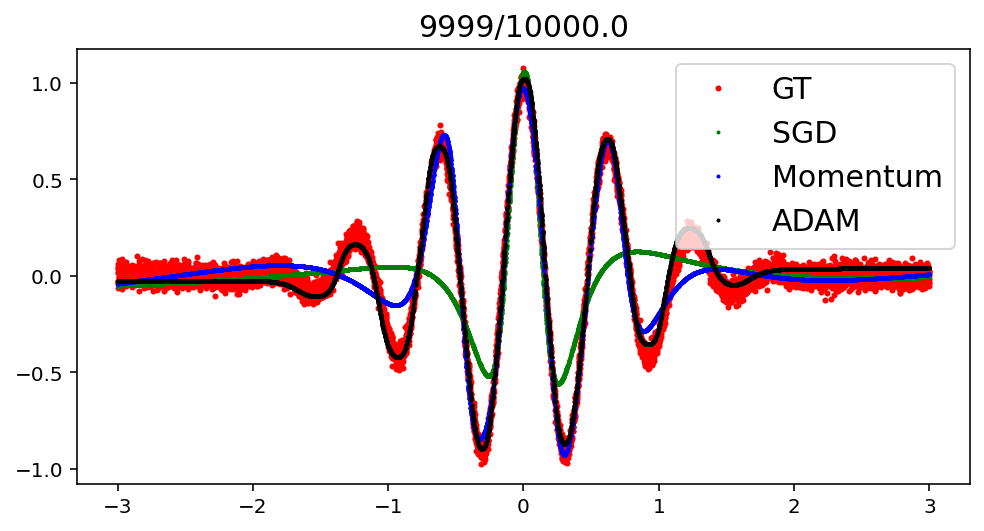

In [25]:
MAX_ITER, BATCH_SIZE, PLOT_EVERY = 1e4, 64, 500

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x, batch_y = x_torch[r_idx], y_torch[r_idx]

    # Adam
    y_pred_adam = model_adam.forward(batch_x)
    loss_adam = loss(y_pred_adam, batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()

    # Momentum
    y_pred_momentum = model_momentum.forward(batch_x)
    loss_momentum = loss(y_pred_momentum, batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()

    # SGD
    y_pred_sgd = model_sgd.forward(batch_x)
    loss_sgd = loss(y_pred_sgd, batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()

    # Plot
    if ((it%PLOT_EVERY) == 0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()

            plt.figure(figsize=(8,4))
            plt.plot(x_numpy, y_numpy, 'r.', ms=4, label='GT')
            plt.plot(x_numpy, y_sgd_numpy, 'g.', ms=2, label='SGD')
            plt.plot(x_numpy, y_momentum_numpy, 'b.', ms=2, label='Momentum')
            plt.plot(x_numpy, y_adam_numpy, 'k.', ms=2, label='ADAM')
            plt.title(f"{it}/{MAX_ITER}", fontsize=15)
            plt.legend(loc='upper right', fontsize=15)
            plt.show()
